# Figure 6: Simulation Origin Probabilities (SOPs)

This notebook generates Figure 6 showing simulation origin probabilities (SOPs) using two different calculation methods:

1. **Method 1 (Main text)**: Galaxy count weighted approach (`bias=True`)
2. **Method 2 (SOPs v2)**: Equal weighting approach (`bias=False`)

The figure shows:
- **Contour plots**: Probability density distributions across UMAP space using filled contours
- **Cell averages**: Battleship grid with dominant simulation colors and probability values
- **Average SFHs**: Star formation history insets for each populated grid cell
- **SOP bar chart insets**: Probability distributions and method comparisons for specific cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from matplotlib.patches import Rectangle
import sys
import pickle
import cmasher as cmr

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, P_s_x, P_x_s,
                           SM_axis_label, sSFR_axis_label)
from utils.plotting import (draw_battleship_grid, is_dark, draw_grid_C, 
                           plot_points, plot_averages, plot_sop_contours)

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data and Reconstruct UMAP Structure

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Reconstructed UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Reconstructed UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


## Create Battleship Grid Structure and Calculate Average SFHs

In [3]:
# Create result array with UMAP coordinates and labels
result = np.column_stack((embedding, combined_labels))

# Create battleship grid structure - divide UMAP space into 10x10 grid
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
non_empty_cells = 0
for i in range(10):
    for j in range(10):
        if umaps[i,j].shape[0] > 0:
            non_empty_cells += 1
            
print(f"  Non-empty grid cells: {non_empty_cells}/100")

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: {type(avg_sfh)} with shape {avg_sfh.shape}")

# Create meshgrid for evaluation
xx, yy = np.mgrid[0:10:100j, 0:10:100j]
pos = np.vstack([xx.ravel(), yy.ravel()])

Created battleship grid (10x10):
  Non-empty grid cells: 69/100

Calculated average SFHs per cell: <class 'numpy.ndarray'> with shape (10, 10, 3, 136)


## Calculate Simulation Origin Probabilities

SOPs are calculated via Bayes' Rule:
$$
\begin{align}
P (\textrm{sim} | \vec{x}) &= \frac{P(\vec{x}|\textrm{sim}) P(\textrm{sim})}{P(\vec{x})} \\
\end{align}
$$

The $P(\vec{x}|\textrm{sim})$ term is approximated via a KDE, and the latter "prior" is computed either as proportional to the galaxy counts from that sim ("weighted") or evenly across all simulations ("unweighted"). The denominator is a normalization term to ensure the probabilities sum to 1.

In [4]:
# Method 1: Galaxy count weighted approach (bias=True, normint=False)
print("Calculating SOPs - Method 1 (Galaxy count weighting):")
p_s_x = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
              normint=False, bias=True, mask=False)

print("Method 1 SOPs calculated for simulations:")
for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

Calculating SOPs - Method 1 (Galaxy count weighting):
Method 1 SOPs calculated for simulations:
          EAGLE: Max probability = 0.3880
      Illustris: Max probability = 0.8358
   IllustrisTNG: Max probability = 0.5500
         Mufasa: Max probability = 0.3840
          Simba: Max probability = 0.4560
         SC-SAM: Max probability = 0.9566
UniverseMachine: Max probability = 0.7109


In [5]:
from scipy.interpolate import RegularGridInterpolator

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x[sim].reshape(100, 100)
        # Create interpolator
        p_s_x_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x_eval[sim] = p_s_x_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x_eval[sim][i] /= total

## Generate Figure 6: Simulation Origin Probabilities (Method 1)

Create multi-panel figure with grid, probability distributions, and SFH insets.

d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)
C:\Users\joshs\AppData\Local\Temp\ipykernel_11864\1931515988.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


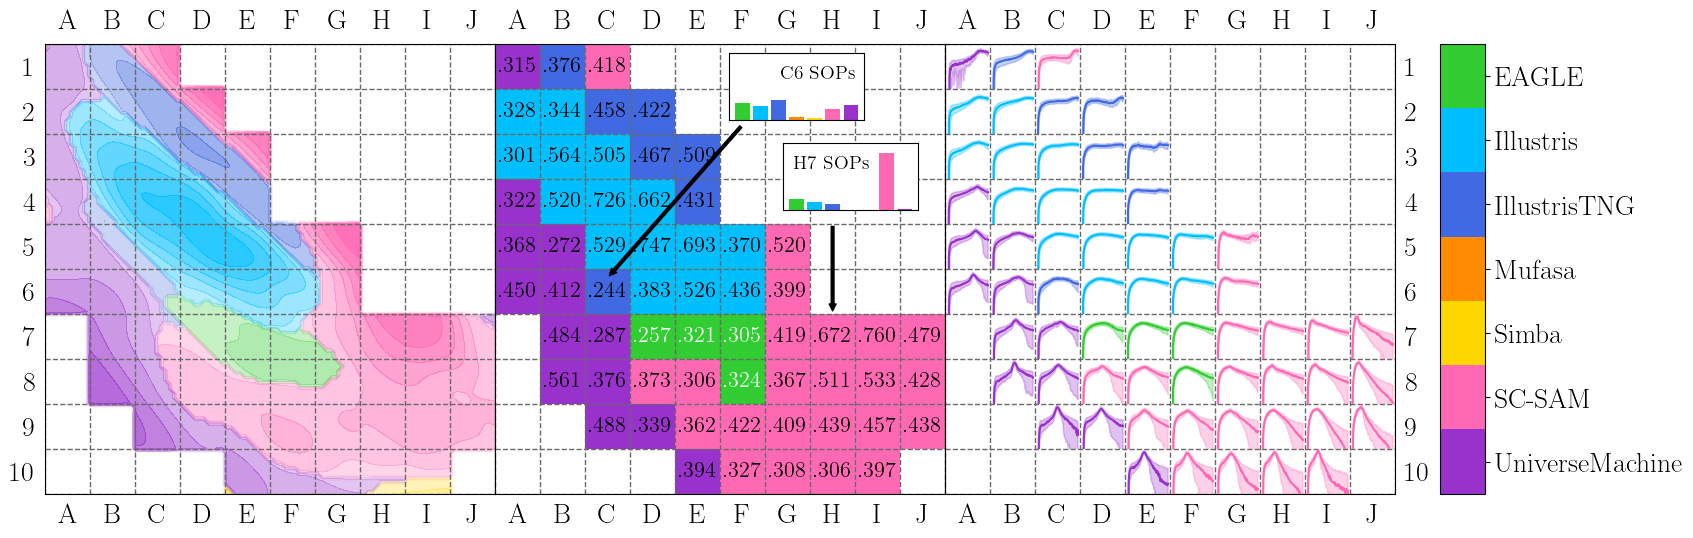

Figure 6 (Weighted SOPs) generated successfully!


In [64]:
# Generate Figure 6: Simulation Origin Probabilities (Method 1) 
# Using standard grid layout with proper contour plotting

# Create custom colormap comprised of base colors
from matplotlib.colors import ListedColormap

sim_cmap = ListedColormap([colors[sim] for sim in sim_name][::-1])

# Use draw_grid_C for consistent layout
fig, ax, norm = draw_grid_C(cmap=sim_cmap, vmin=0, vmax=7)

# Plot 1: Contour plot of SOPs (instead of scatter)
plot_sop_contours(p_s_x, sim_name, colors, fig, ax[0], cax=None, 
                 label='Simulation Origin Probability')

# Plot 2: Cell averages for SOPs
# Calculate cell averages
p_avg = dict.fromkeys(sim_name)
for sim in sim_name:
    p_avg[sim] = boxing(x=embedding[:,0], y=embedding[:,1], z=p_s_x_eval[sim], average=True)

# Find dominant simulation per cell
p_stack_cell = np.array([p_avg[sim] for sim in sim_name])
p_stack_cell = np.nan_to_num(p_stack_cell, nan=0.0)
max_idx = np.argmax(p_stack_cell, axis=0)
max_idx = len(sim_name) - 1 - max_idx  # flip

# Plot cell averages
for i in range(10):
    for j in range(10):
        count = umaps[i,j].shape[0]
        if count >= 100:
            dom_sim_idx = max_idx[i, j]
            p = np.nanmax(p_stack_cell[:, i, j])
            colour = colors[sim_name[dom_sim_idx]]
            
            # Determine text color
            rgba_color = mpl.colors.to_rgba(colour)
            textc = 'white' if is_dark(rgba_color) else 'black'

            # Draw colored cell
            ax[1].text(i+0.5, j+0.5, f'{p:.3f}'.lstrip('0'), 
                      va='center', ha='center', c=textc, fontsize=16)

# Plot 3: Average SFHs using standard function
plot_averages(avg=max_idx + 1e-5, avg_sfh=avg_sfh, fig=fig, ax1=ax[1], ax2=ax[2], 
              umaps=umaps, cmap=sim_cmap, norm=norm, plot_text=False, plot_cells=True)

# Add SOP insets for specific cells
ins1 = ax[1].inset_axes([0.52, 0.83, 0.3, 0.15], facecolor='white', zorder=21)
ins2 = ax[1].inset_axes([0.64, 0.63, 0.3, 0.15], facecolor='white', zorder=21)

# Cell C6 (i=2, j=6)
if p_stack_cell.shape[2] > 6 and p_stack_cell.shape[1] > 2:
    ins1.bar(range(len(sim_name)), p_stack_cell[:, 2, -6], 
             color=[colors[sim] for sim in sim_name])
    ins1.text(6.3, 0.65, 'C6 SOPs', ha='right', va='top', fontsize=14)

# Cell H7 (i=7, j=7)  
if p_stack_cell.shape[2] > 1 and p_stack_cell.shape[1] > 7:
    ins2.bar(range(len(sim_name)), p_stack_cell[:, 7, -7], 
             color=[colors[sim] for sim in sim_name])
    ins2.text(4.0, 0.65, 'H7 SOPs', ha='right', va='top', fontsize=14)

for ins in [ins1, ins2]:
    ins.patch.set_color('w')
    ins.tick_params(which='both', left=False, right=False, top=False, bottom=False,
                    labelleft=False, labelright=False, labeltop=False, labelbottom=False)
    ins.set_ylim(0, 0.8)

# Add arrows
an1 = ax[1].annotate("",
                    xy=(0.25, 0.48), xycoords='axes fraction',
                    xytext=(0.55, 0.82), textcoords='axes fraction',
                    size=10, va="center", ha="center",
                    arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.0", color='k'), 
                    zorder=30)

an2 = ax[1].annotate("",
                    xy=(0.75, 0.4), xycoords='axes fraction', 
                    xytext=(0.75, 0.6), textcoords='axes fraction',
                    size=10, va="center", ha="center",
                    arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.0", color='k'), 
                    zorder=30)

# Colorbar setup
if ax[-1] is not None:
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=sim_cmap),
                cax=ax[-1], orientation='vertical')
    cbar.ax.set_yticks(np.linspace(0,6,7)+0.5, labels=sim_name[::-1], fontsize=20)
    cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

# Save figure
plt.savefig('../figures/umap_sops_weighted.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/umap_sops_weighted.pdf', bbox_inches='tight')

plt.show()

print("Figure 6 (Weighted SOPs) generated successfully!")

In [65]:
# Method 2: Equal weighting approach (bias=False, normint=False)
print("Calculating SOPs - Method 2 (Equal weighting):")
p_s_x2 = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
               normint=False, bias=False, mask=False)

print("Method 2 SOPs calculated for simulations:")
for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x2[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

Calculating SOPs - Method 2 (Equal weighting):
Method 2 SOPs calculated for simulations:
          EAGLE: Max probability = 0.4861
      Illustris: Max probability = 0.7024
   IllustrisTNG: Max probability = 0.4853
         Mufasa: Max probability = 0.6282
          Simba: Max probability = 0.6689
         SC-SAM: Max probability = 0.8865
UniverseMachine: Max probability = 0.4270


In [66]:
from scipy.interpolate import RegularGridInterpolator

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x2_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x2[sim].reshape(100, 100)
        # Create interpolator
        p_s_x2_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x2_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x2_eval[sim] = p_s_x2_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x2_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x2_eval[sim][i] /= total

d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)
C:\Users\joshs\AppData\Local\Temp\ipykernel_11864\475074008.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


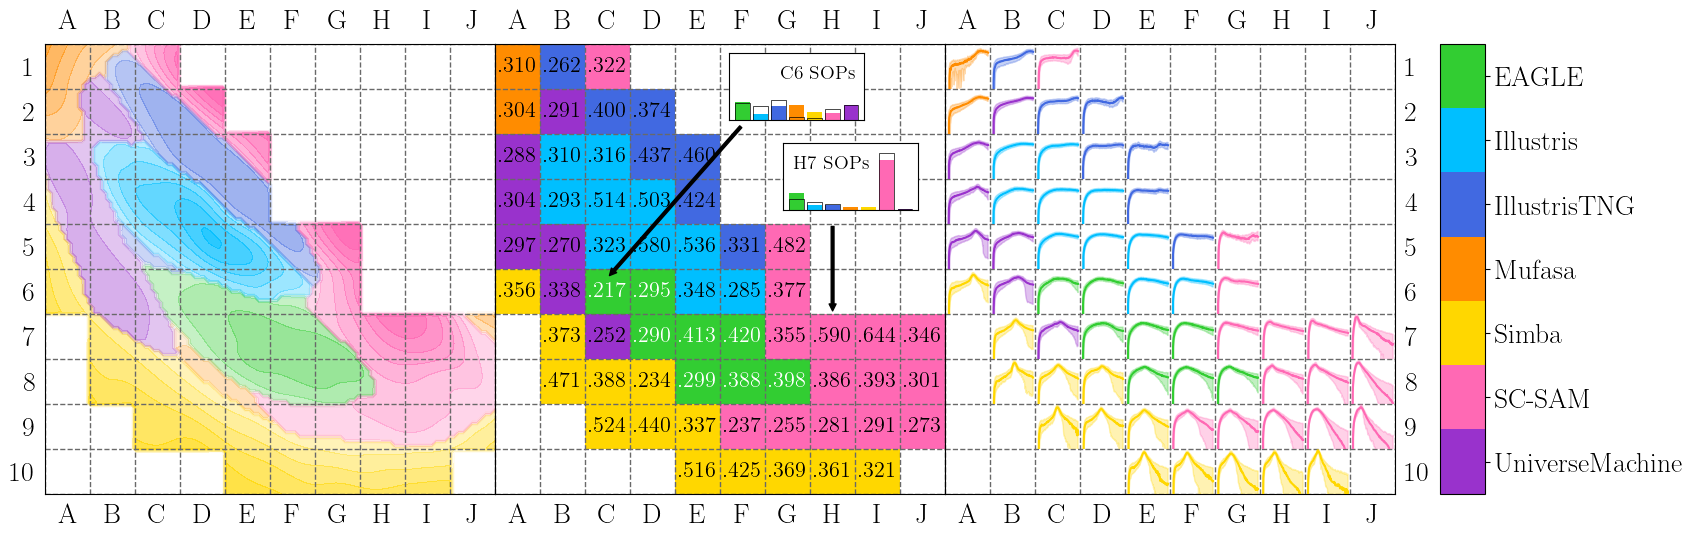

Figure 6 (Uniform SOPs) generated successfully!


In [73]:
# Generate Figure 6: Simulation Origin Probabilities (Method 1) 
# Using standard grid layout with proper contour plotting

# Create custom colormap comprised of base colors
from matplotlib.colors import ListedColormap

sim_cmap = ListedColormap([colors[sim] for sim in sim_name][::-1])

# Use draw_grid_C for consistent layout
fig, ax, norm = draw_grid_C(cmap=sim_cmap, vmin=0, vmax=7)

# Plot 1: Contour plot of SOPs (instead of scatter)
plot_sop_contours(p_s_x2, sim_name, colors, fig, ax[0], cax=None, 
                 label='Simulation Origin Probability')

# Plot 2: Cell averages for SOPs
# Calculate cell averages
p_avg2 = dict.fromkeys(sim_name)
for sim in sim_name:
    p_avg2[sim] = boxing(x=embedding[:,0], y=embedding[:,1], z=p_s_x2_eval[sim], average=True)

# Find dominant simulation per cell
p_stack_cell2 = np.array([p_avg2[sim] for sim in sim_name])
p_stack_cell2 = np.nan_to_num(p_stack_cell2, nan=0.0)
max_idx2 = np.argmax(p_stack_cell2, axis=0)
max_idx2 = len(sim_name) - 1 - max_idx2  # flip

# Plot cell averages
for i in range(10):
    for j in range(10):
        count = umaps[i,j].shape[0]
        if count >= 100:
            dom_sim_idx = max_idx2[i, j]
            p = np.nanmax(p_stack_cell2[:, i, j])
            colour = colors[sim_name[dom_sim_idx]]
            
            # Determine text color
            rgba_color = mpl.colors.to_rgba(colour)
            textc = 'white' if is_dark(rgba_color) else 'black'

            # Draw colored cell
            ax[1].text(i+0.5, j+0.5, f'{p:.3f}'.lstrip('0'), 
                      va='center', ha='center', c=textc, fontsize=16)

# Plot 3: Average SFHs using standard function
plot_averages(avg=max_idx2 + 1e-5, avg_sfh=avg_sfh, fig=fig, ax1=ax[1], ax2=ax[2], 
              umaps=umaps, cmap=sim_cmap, norm=norm, plot_text=False, plot_cells=True)

# Add SOP insets for specific cells
ins1 = ax[1].inset_axes([0.52, 0.83, 0.3, 0.15], facecolor='white', zorder=21)
ins2 = ax[1].inset_axes([0.64, 0.63, 0.3, 0.15], facecolor='white', zorder=21)

# Cell C6 (i=2, j=6)
if p_stack_cell2.shape[2] > 6 and p_stack_cell2.shape[1] > 2:
    ins1.bar(range(len(sim_name)), p_stack_cell2[:, 2, -6], 
             color=[colors[sim] for sim in sim_name])
    ins1.bar(range(len(sim_name)), p_stack_cell[:, 2, -6],
             facecolor='none',
             edgecolor=['k' for i in range(len(sim_name))],
             linewidth=0.5)
    ins1.text(6.3, 0.65, 'C6 SOPs', ha='right', va='top', fontsize=14)

# Cell H7 (i=7, j=7)  
if p_stack_cell2.shape[2] > 1 and p_stack_cell2.shape[1] > 7:
    ins2.bar(range(len(sim_name)), p_stack_cell2[:, 7, -7], 
             color=[colors[sim] for sim in sim_name])
    ins2.bar(range(len(sim_name)), p_stack_cell[:, 7, -7],
             facecolor='none',
             edgecolor=['k' for i in range(len(sim_name))],
             linewidth=0.5)
    ins2.text(4.0, 0.65, 'H7 SOPs', ha='right', va='top', fontsize=14)

for ins in [ins1, ins2]:
    ins.patch.set_color('w')
    ins.tick_params(which='both', left=False, right=False, top=False, bottom=False,
                    labelleft=False, labelright=False, labeltop=False, labelbottom=False)
    ins.set_ylim(0, 0.8)

# Add arrows
an1 = ax[1].annotate("",
                    xy=(0.25, 0.48), xycoords='axes fraction',
                    xytext=(0.55, 0.82), textcoords='axes fraction',
                    size=10, va="center", ha="center",
                    arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.0", color='k'), 
                    zorder=30)

an2 = ax[1].annotate("",
                    xy=(0.75, 0.4), xycoords='axes fraction', 
                    xytext=(0.75, 0.6), textcoords='axes fraction',
                    size=10, va="center", ha="center",
                    arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.0", color='k'), 
                    zorder=30)

# Colorbar setup
if ax[-1] is not None:
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=sim_cmap),
                cax=ax[-1], orientation='vertical')
    cbar.ax.set_yticks(np.linspace(0,6,7)+0.5, labels=sim_name[::-1], fontsize=20)
    cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

# Save figure
plt.savefig('../figures/umap_sops_uniform.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/umap_sops_uniform.pdf', bbox_inches='tight')

plt.show()

print("Figure 6 (Uniform SOPs) generated successfully!")